C:\Users\kelvi\AppData\Local\Temp\ipykernel_20160\3382927599.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cadence = df.groupby("Linha").apply(cadence_stats).reset_index()


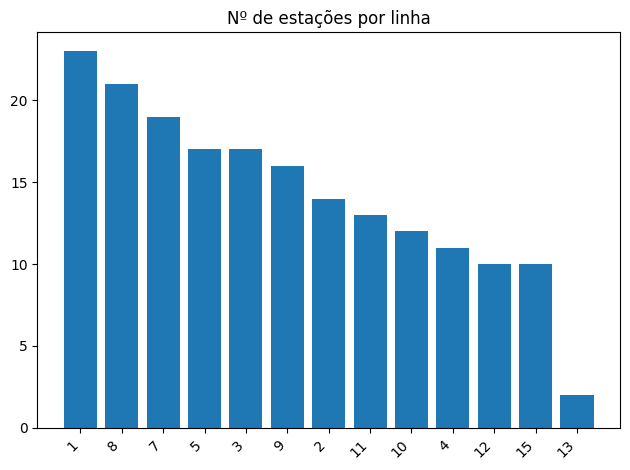

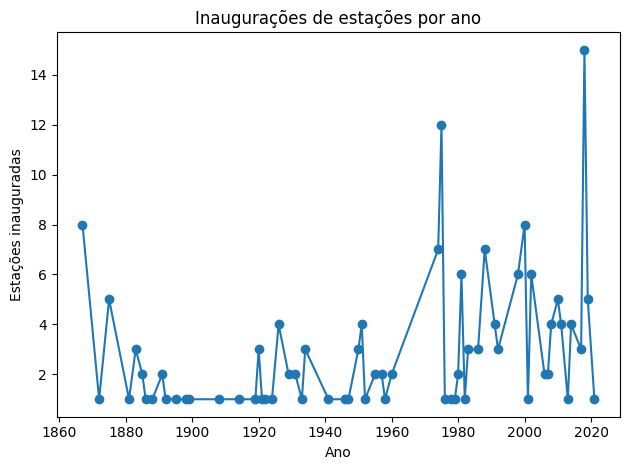

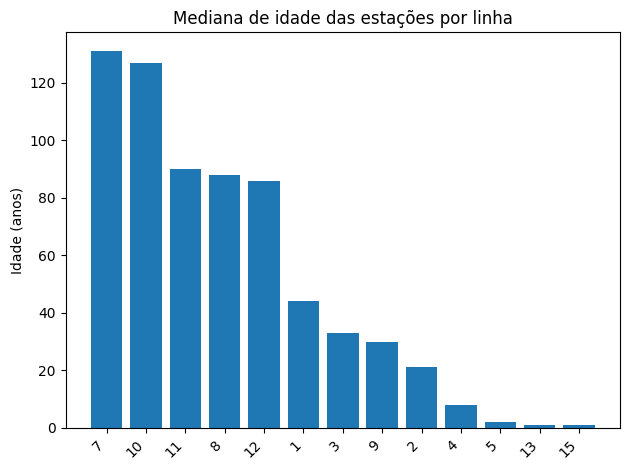

C:\Users\kelvi\AppData\Local\Temp\ipykernel_20160\3382927599.py:112: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(age_for_box, labels=lines_for_box, vert=True)


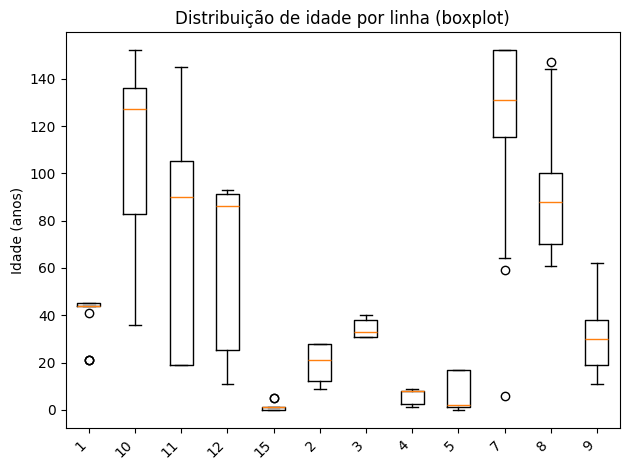

In [21]:
# Anal√≠tica explorat√≥ria e gr√°ficos do dataset do Metr√¥ SP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Carrega o CSV reordenado se existir; sen√£o, o original
try:
    df = pd.read_csv("C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv")
except FileNotFoundError:
    df = pd.read_csv("C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv")

# Normaliza√ß√µes b√°sicas
df["Linha"] = df["Linha"].astype(str).str.strip()
df["Nome"] = df["Nome"].astype(str).str.strip()

# Parse de datas
def try_parse_date(x):
    try:
        return pd.to_datetime(x, errors="coerce")
    except Exception:
        return pd.NaT

if "Inaugura√ß√£o" in df.columns:
    df["Inaugura√ß√£o_dt"] = pd.to_datetime(df["Inaugura√ß√£o"], errors="coerce")
else:
    df["Inaugura√ß√£o_dt"] = pd.NaT

# Idade: se j√° existir, mant√©m; caso contr√°rio, calcula por data de inaugura√ß√£o
if "Idade" not in df.columns or df["Idade"].isna().all():
    today = pd.Timestamp("2025-10-23")
    df["Idade_calc"] = np.where(df["Inaugura√ß√£o_dt"].notna(),
                                (today - df["Inaugura√ß√£o_dt"]).dt.days // 365,
                                np.nan)
    idade_col = "Idade_calc"
else:
    idade_col = "Idade"

# 1) Contagem de esta√ß√µes por linha (ranking)
stations_by_line = df.groupby("Linha")["Nome"].nunique().sort_values(ascending=False).reset_index(name="N¬∫ esta√ß√µes")

# 2) Mediana e dispers√£o da idade por linha
age_stats = df.groupby("Linha")[idade_col].agg(["median","mean","min","max","count"]).rename(columns={
    "median":"Mediana idade",
    "mean":"M√©dia idade",
    "min":"M√≠nima idade",
    "max":"M√°xima idade",
    "count":"N¬∫ esta√ß√µes (c/ idade)"
}).sort_values("Mediana idade", ascending=False).reset_index()

# 3) Top 10 esta√ß√µes mais antigas e mais novas
oldest = df.sort_values(idade_col, ascending=False)[["Nome","Linha","Inaugura√ß√£o","Inaugura√ß√£o_dt",idade_col]].head(10).reset_index(drop=True)
newest = df.sort_values(idade_col, ascending=True)[["Nome","Linha","Inaugura√ß√£o","Inaugura√ß√£o_dt",idade_col]].head(10).reset_index(drop=True)

# 4) S√©rie hist√≥rica de inaugura√ß√µes por ano (todas as linhas)
ts = df.dropna(subset=["Inaugura√ß√£o_dt"]).copy()
ts["ano"] = ts["Inaugura√ß√£o_dt"].dt.year
openings_by_year = ts.groupby("ano")["Nome"].count().rename("Esta√ß√µes inauguradas").reset_index()

# 5) M√©trica de cad√™ncia de expans√£o: anos entre inaugura√ß√µes por linha (mediana)
def cadence_stats(g):
    g = g.dropna(subset=["Inaugura√ß√£o_dt"]).sort_values("Inaugura√ß√£o_dt")
    if len(g) < 2:
        return pd.Series({"Mediana intervalo (anos)": np.nan, "P95 intervalo (anos)": np.nan, "√öltima inaugura√ß√£o": g["Inaugura√ß√£o_dt"].max()})
    gaps = g["Inaugura√ß√£o_dt"].diff().dropna().dt.days / 365.25
    return pd.Series({
        "Mediana intervalo (anos)": gaps.median(),
        "P95 intervalo (anos)": gaps.quantile(0.95),
        "√öltima inaugura√ß√£o": g["Inaugura√ß√£o_dt"].max()
    })

cadence = df.groupby("Linha").apply(cadence_stats).reset_index()

# ===== Gr√°ficos =====
# 1. Barras: n¬∫ de esta√ß√µes por linha
plt.figure()
plt.bar(stations_by_line["Linha"], stations_by_line["N¬∫ esta√ß√µes"])
plt.xticks(rotation=45, ha="right")
plt.title("N¬∫ de esta√ß√µes por linha")
plt.tight_layout()
plt.show()

# 2. Linha: inaugura√ß√µes por ano
plt.figure()
plt.plot(openings_by_year["ano"], openings_by_year["Esta√ß√µes inauguradas"], marker="o")
plt.title("Inaugura√ß√µes de esta√ß√µes por ano")
plt.xlabel("Ano")
plt.ylabel("Esta√ß√µes inauguradas")
plt.tight_layout()
plt.show()

# 3. Barras: mediana de idade por linha
plt.figure()
plt.bar(age_stats["Linha"], age_stats["Mediana idade"])
plt.xticks(rotation=45, ha="right")
plt.title("Mediana de idade das esta√ß√µes por linha")
plt.ylabel("Idade (anos)")
plt.tight_layout()
plt.show()

# 4. Boxplot de idades por linha (apenas se tiver dados suficientes)
lines_for_box = []
age_for_box = []
for lin, g in df.groupby("Linha"):
    vals = g[idade_col].dropna().values
    if len(vals) >= 3:
        lines_for_box.append(lin)
        age_for_box.append(vals)

if len(age_for_box) >= 1:
    plt.figure()
    plt.boxplot(age_for_box, labels=lines_for_box, vert=True)
    plt.xticks(rotation=45, ha="right")
    plt.title("Distribui√ß√£o de idade por linha (boxplot)")
    plt.ylabel("Idade (anos)")
    plt.tight_layout()
    plt.show()



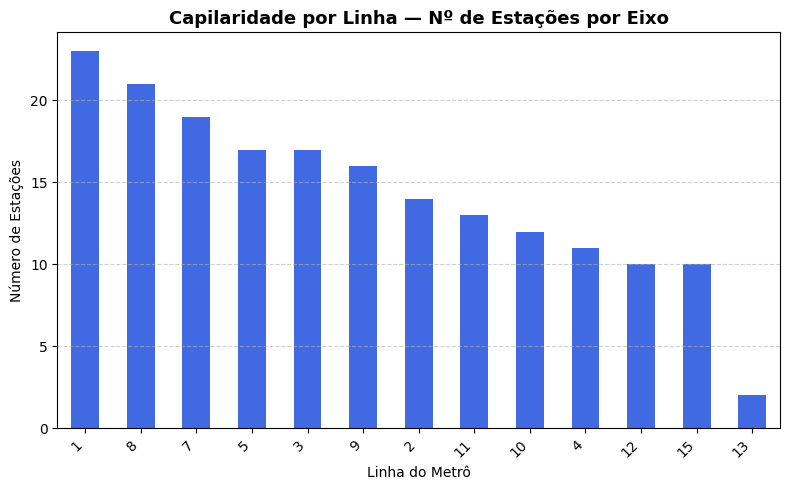

<Figure size 800x500 with 0 Axes>

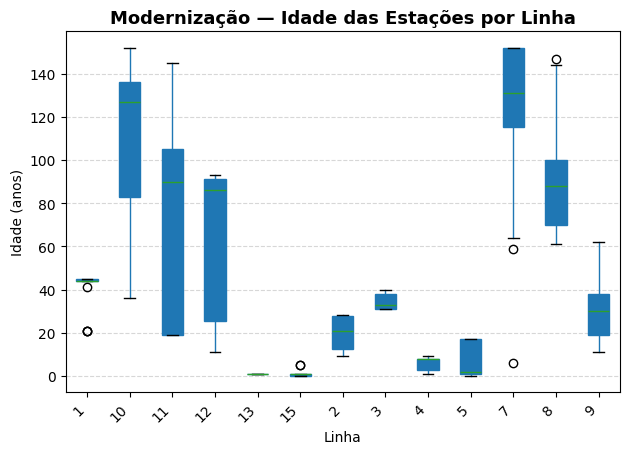

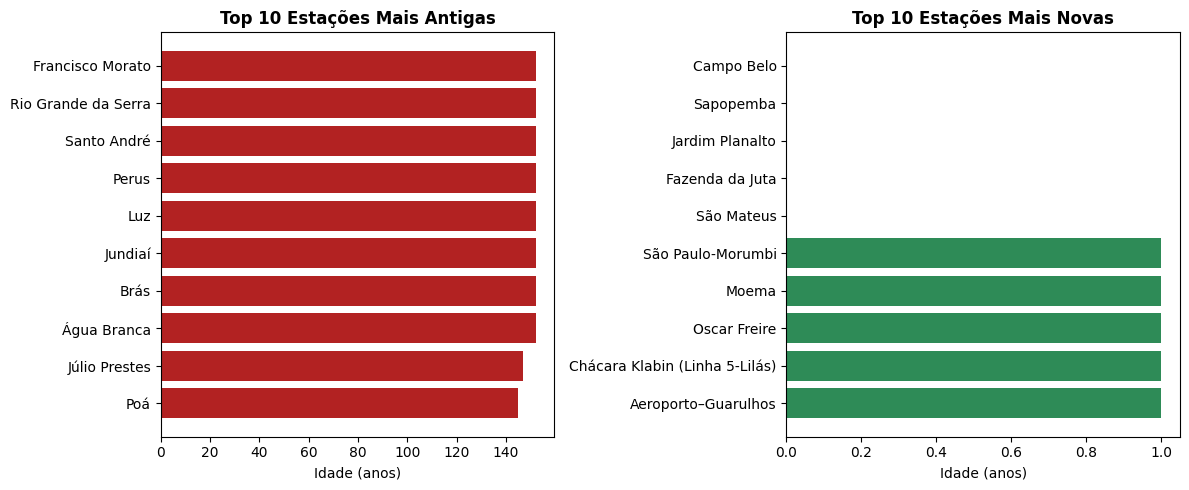

C:\Users\kelvi\AppData\Local\Temp\ipykernel_20160\3905544350.py:80: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cadencia_por_linha = df.groupby("Linha").apply(cadencia).dropna().sort_values()


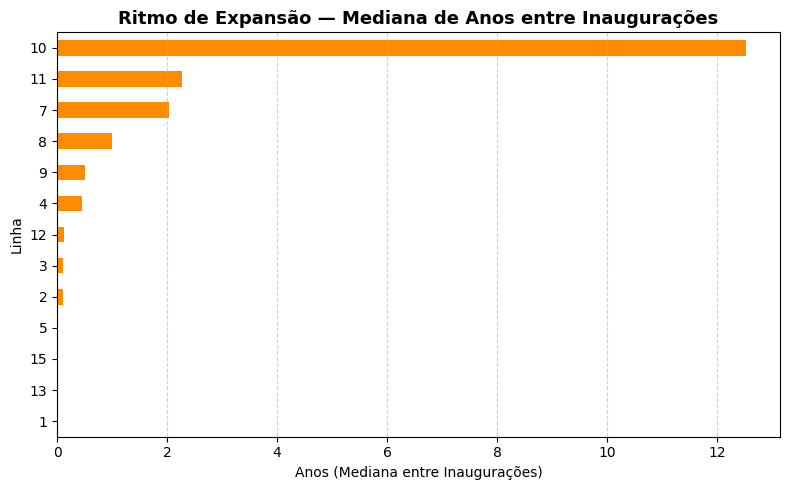

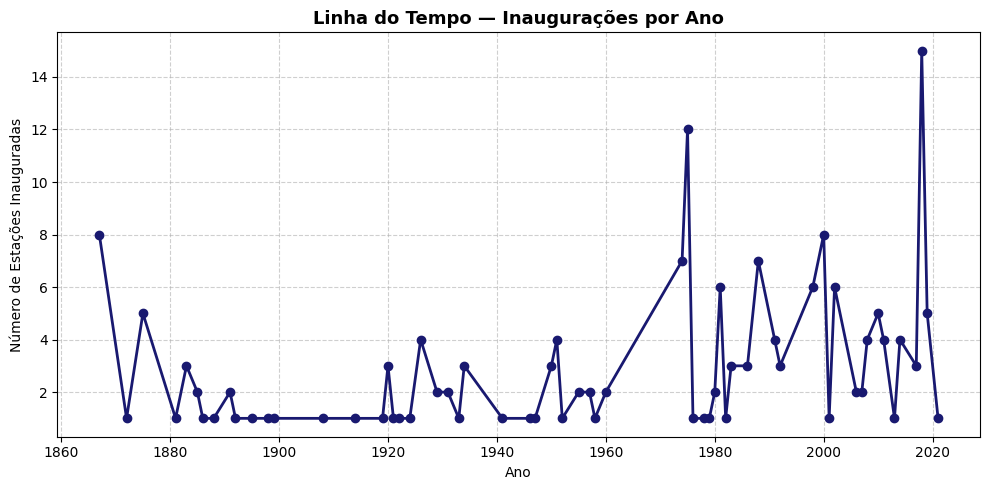

üîπ Indicadores Executivos de Sa√∫de da Rede

‚û°Ô∏è % de esta√ß√µes com idade > 40 anos: 47.6%
‚û°Ô∏è Mediana de idade da rede: 38.0 anos
‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 5 anos: 1
‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 10 anos: 24

Gap de expans√£o (anos desde √∫ltima inaugura√ß√£o):


Linha
8     67.441096
10    42.416438
3     36.873973
1     27.504110
11    25.424658
9     17.517808
12    17.282192
2     15.098630
7     12.128767
13     7.569863
5      6.547945
15     5.857534
4      3.852055
Name: Inaugura√ß√£o_dt, dtype: float64

In [22]:
# ----------------------------------------
# Dashboard Anal√≠tico do Metr√¥ de S√£o Paulo 
# e Companhia Paulista de Trens Metropolitanos (CPTM)
# ----------------------------------------
# Gera plots sobre capilaridade, moderniza√ß√£o,
# prioridades estruturais, cad√™ncia e outros indicadores
# ----------------------------------------
# (Dataset do ano de 2019)

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ========= LEITURA E PREPARA√á√ÉO =========
df = pd.read_csv("C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv")

# Padroniza colunas
df["Linha"] = df["Linha"].astype(str).str.strip()
df["Nome"] = df["Nome"].astype(str).str.strip()
df["Inaugura√ß√£o_dt"] = pd.to_datetime(df["Inaugura√ß√£o"], errors="coerce")

# Se n√£o houver idade, calcula
if "Idade" not in df.columns or df["Idade"].isna().all():
    today = pd.Timestamp("2025-10-23")
    df["Idade"] = (today - df["Inaugura√ß√£o_dt"]).dt.days // 365

# ========= 1Ô∏è‚É£ CAPILARIDADE =========
plt.figure(figsize=(8,5))
station_counts = df.groupby("Linha")["Nome"].nunique().sort_values(ascending=False)
station_counts.plot(kind="bar", color="royalblue")
plt.title("Capilaridade por Linha ‚Äî N¬∫ de Esta√ß√µes por Eixo", fontsize=13, weight="bold")
plt.ylabel("N√∫mero de Esta√ß√µes")
plt.xlabel("Linha do Metr√¥")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ========= 2Ô∏è‚É£ MODERNIZA√á√ÉO (IDADE) =========
plt.figure(figsize=(8,5))
df.boxplot(column="Idade", by="Linha", grid=False, patch_artist=True)
plt.title("Moderniza√ß√£o ‚Äî Idade das Esta√ß√µes por Linha", fontsize=13, weight="bold")
plt.suptitle("")  # remove t√≠tulo autom√°tico
plt.ylabel("Idade (anos)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ========= 3Ô∏è‚É£ ‚ÄúTOP 10‚Äù PRIORIDADES E BENCHMARK =========
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Top 10 mais antigas
top_old = df.sort_values("Idade", ascending=False).head(10)
ax[0].barh(top_old["Nome"], top_old["Idade"], color="firebrick")
ax[0].invert_yaxis()
ax[0].set_title("Top 10 Esta√ß√µes Mais Antigas", fontsize=12, weight="bold")
ax[0].set_xlabel("Idade (anos)")

# Top 10 mais novas
top_new = df.sort_values("Idade", ascending=True).head(10)
ax[1].barh(top_new["Nome"], top_new["Idade"], color="seagreen")
ax[1].invert_yaxis()
ax[1].set_title("Top 10 Esta√ß√µes Mais Novas", fontsize=12, weight="bold")
ax[1].set_xlabel("Idade (anos)")

plt.tight_layout()
plt.show()

# ========= 4Ô∏è‚É£ RITMO DE EXPANS√ÉO (CAD√äNCIA) =========
def cadencia(grupo):
    grupo = grupo.dropna(subset=["Inaugura√ß√£o_dt"]).sort_values("Inaugura√ß√£o_dt")
    if len(grupo) < 2:
        return np.nan
    diffs = grupo["Inaugura√ß√£o_dt"].diff().dropna().dt.days / 365.25
    return diffs.median()

cadencia_por_linha = df.groupby("Linha").apply(cadencia).dropna().sort_values()

plt.figure(figsize=(8,5))
cadencia_por_linha.plot(kind="barh", color="darkorange")
plt.title("Ritmo de Expans√£o ‚Äî Mediana de Anos entre Inaugura√ß√µes", fontsize=13, weight="bold")
plt.xlabel("Anos (Mediana entre Inaugura√ß√µes)")
plt.ylabel("Linha")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ========= 5Ô∏è‚É£ LINHA DO TEMPO DAS INAUGURA√á√ïES =========
df["ano"] = df["Inaugura√ß√£o_dt"].dt.year
openings = df.dropna(subset=["ano"]).groupby("ano")["Nome"].count()

plt.figure(figsize=(10,5))
plt.plot(openings.index, openings.values, marker="o", color="midnightblue", linewidth=2)
plt.title("Linha do Tempo ‚Äî Inaugura√ß√µes por Ano", fontsize=13, weight="bold")
plt.xlabel("Ano")
plt.ylabel("N√∫mero de Esta√ß√µes Inauguradas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ========= 6Ô∏è‚É£ INDICADORES EXECUTIVOS =========
hoje = pd.Timestamp("2025-10-23")
df["anos_desde_inaug"] = (hoje - df["Inaugura√ß√£o_dt"]).dt.days / 365

# % de esta√ß√µes > 40 anos
pct_antigas = (df["Idade"] > 40).mean() * 100

# Mediana de idade total
mediana_idade = df["Idade"].median()

# Esta√ß√µes inauguradas nos √∫ltimos 5 e 10 anos
recent_5 = (df["Inaugura√ß√£o_dt"] > (hoje - pd.Timedelta(days=5*365))).sum()
recent_10 = (df["Inaugura√ß√£o_dt"] > (hoje - pd.Timedelta(days=10*365))).sum()

# Gap de expans√£o: anos desde √∫ltima inaugura√ß√£o por linha
ultimo = df.groupby("Linha")["Inaugura√ß√£o_dt"].max()
gap = (hoje - ultimo).dt.days / 365

# Mostra KPIs
print("üîπ Indicadores Executivos de Sa√∫de da Rede\n")
print(f"‚û°Ô∏è % de esta√ß√µes com idade > 40 anos: {pct_antigas:.1f}%")
print(f"‚û°Ô∏è Mediana de idade da rede: {mediana_idade:.1f} anos")
print(f"‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 5 anos: {recent_5}")
print(f"‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 10 anos: {recent_10}\n")
print("Gap de expans√£o (anos desde √∫ltima inaugura√ß√£o):")
display(gap.sort_values(ascending=False))


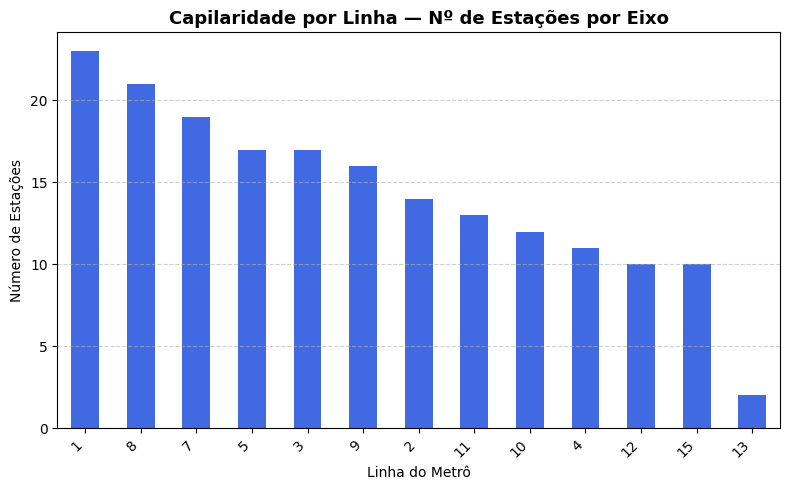

<Figure size 800x500 with 0 Axes>

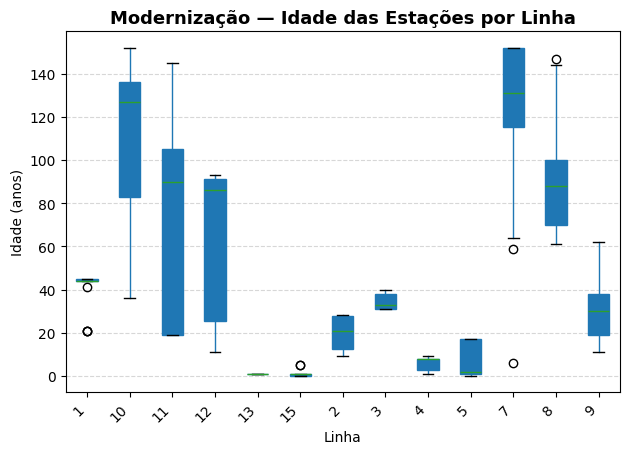

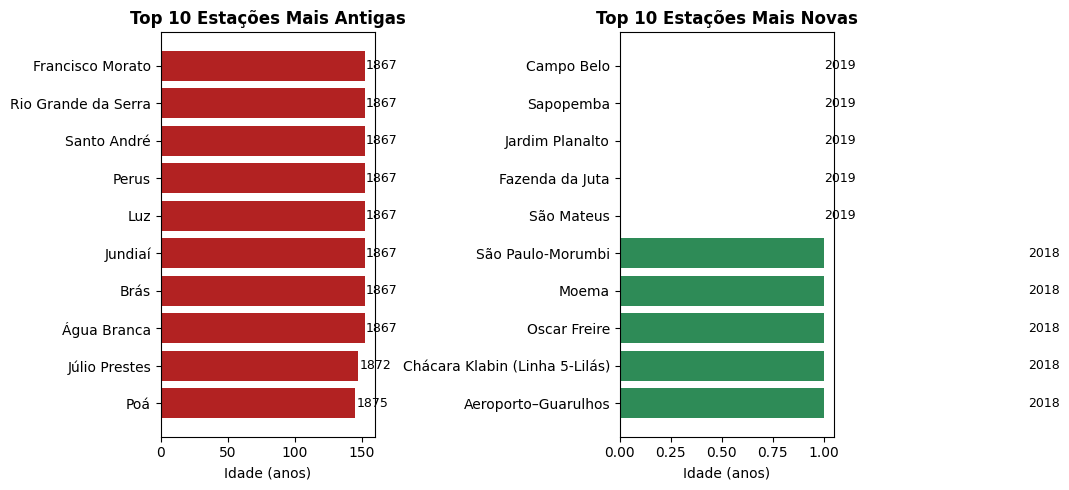

C:\Users\kelvi\AppData\Local\Temp\ipykernel_20160\1502237932.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cadencia_por_linha = df.groupby("Linha").apply(cadencia).dropna().sort_values()


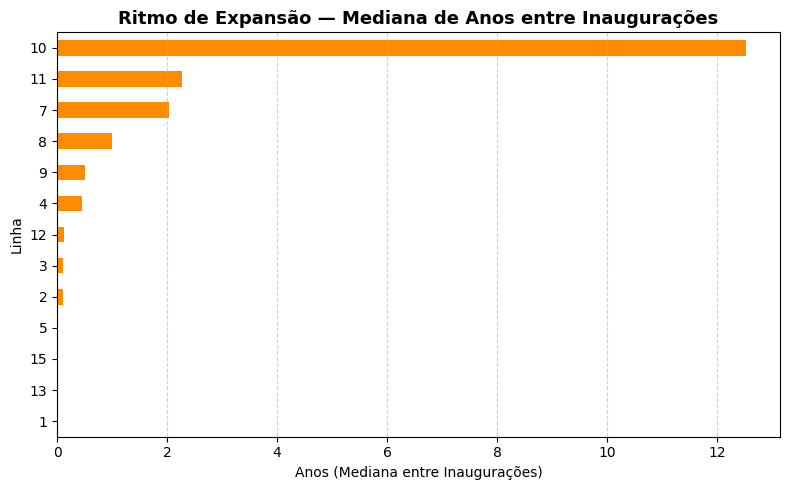

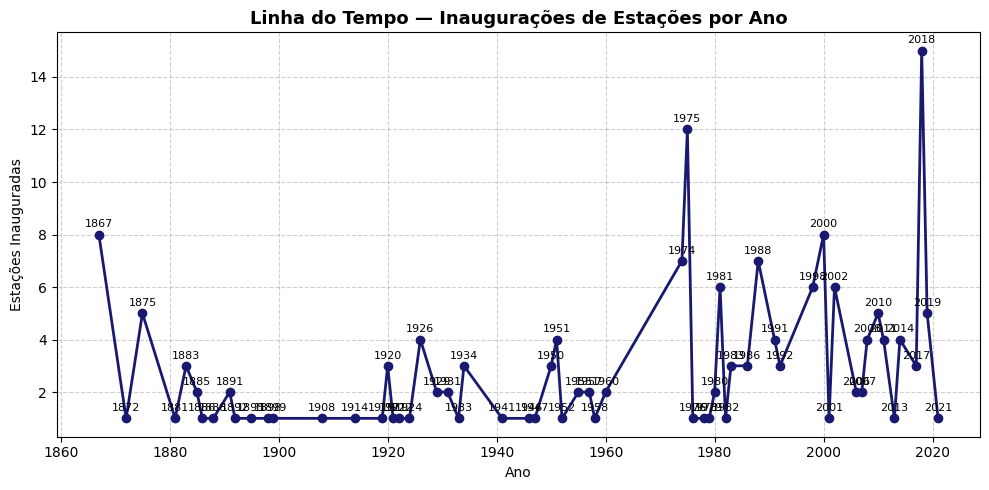

üîπ Indicadores Executivos de Sa√∫de da Rede

‚û°Ô∏è % de esta√ß√µes com idade > 40 anos: 47.6%
‚û°Ô∏è Mediana de idade da rede: 38.0 anos
‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 5 anos: 1
‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 10 anos: 24

Gap de expans√£o (anos desde √∫ltima inaugura√ß√£o):


Linha
8     67.441096
10    42.416438
3     36.873973
1     27.504110
11    25.424658
9     17.517808
12    17.282192
2     15.098630
7     12.128767
13     7.569863
5      6.547945
15     5.857534
4      3.852055
Name: Inaugura√ß√£o_dt, dtype: float64

In [25]:
# ----------------------------------------
# Dashboard Anal√≠tico do Metr√¥ de S√£o Paulo (v2)
# ----------------------------------------
# Inclui r√≥tulos de ano nos plots principais
# ----------------------------------------

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ========= LEITURA E PREPARA√á√ÉO =========
df = pd.read_csv("C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv")

# Padroniza colunas
df["Linha"] = df["Linha"].astype(str).str.strip()
df["Nome"] = df["Nome"].astype(str).str.strip()
df["Inaugura√ß√£o_dt"] = pd.to_datetime(df["Inaugura√ß√£o"], errors="coerce")
df["Ano"] = df["Inaugura√ß√£o_dt"].dt.year

# Calcula idade se n√£o houver
if "Idade" not in df.columns or df["Idade"].isna().all():
    today = pd.Timestamp("2025-10-23")
    df["Idade"] = (today - df["Inaugura√ß√£o_dt"]).dt.days // 365

# ========= 1Ô∏è‚É£ CAPILARIDADE =========
plt.figure(figsize=(8,5))
station_counts = df.groupby("Linha")["Nome"].nunique().sort_values(ascending=False)
station_counts.plot(kind="bar", color="royalblue")
plt.title("Capilaridade por Linha ‚Äî N¬∫ de Esta√ß√µes por Eixo", fontsize=13, weight="bold")
plt.ylabel("N√∫mero de Esta√ß√µes")
plt.xlabel("Linha do Metr√¥")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ========= 2Ô∏è‚É£ MODERNIZA√á√ÉO (IDADE) =========
plt.figure(figsize=(8,5))
df.boxplot(column="Idade", by="Linha", grid=False, patch_artist=True)
plt.title("Moderniza√ß√£o ‚Äî Idade das Esta√ß√µes por Linha", fontsize=13, weight="bold")
plt.suptitle("")  # remove t√≠tulo autom√°tico
plt.ylabel("Idade (anos)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ========= 3Ô∏è‚É£ ‚ÄúTOP 10‚Äù PRIORIDADES E BENCHMARK =========
fig, ax = plt.subplots(1, 2, figsize=(13,5))

# Top 10 mais antigas
top_old = df.sort_values("Idade", ascending=False).head(10)
ax[0].barh(top_old["Nome"], top_old["Idade"], color="firebrick")
ax[0].invert_yaxis()
ax[0].set_title("Top 10 Esta√ß√µes Mais Antigas", fontsize=12, weight="bold")
ax[0].set_xlabel("Idade (anos)")
for i, (idade, ano) in enumerate(zip(top_old["Idade"], top_old["Ano"])):
    ax[0].text(idade + 1, i, f"{int(ano)}", va="center", fontsize=9, color="black")

# Top 10 mais novas
top_new = df.sort_values("Idade", ascending=True).head(10)
ax[1].barh(top_new["Nome"], top_new["Idade"], color="seagreen")
ax[1].invert_yaxis()
ax[1].set_title("Top 10 Esta√ß√µes Mais Novas", fontsize=12, weight="bold")
ax[1].set_xlabel("Idade (anos)")
for i, (idade, ano) in enumerate(zip(top_new["Idade"], top_new["Ano"])):
    ax[1].text(idade + 1, i, f"{int(ano)}", va="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()

# ========= 4Ô∏è‚É£ RITMO DE EXPANS√ÉO (CAD√äNCIA) =========
def cadencia(grupo):
    grupo = grupo.dropna(subset=["Inaugura√ß√£o_dt"]).sort_values("Inaugura√ß√£o_dt")
    if len(grupo) < 2:
        return np.nan
    diffs = grupo["Inaugura√ß√£o_dt"].diff().dropna().dt.days / 365.25
    return diffs.median()

cadencia_por_linha = df.groupby("Linha").apply(cadencia).dropna().sort_values()

plt.figure(figsize=(8,5))
cadencia_por_linha.plot(kind="barh", color="darkorange")
plt.title("Ritmo de Expans√£o ‚Äî Mediana de Anos entre Inaugura√ß√µes", fontsize=13, weight="bold")
plt.xlabel("Anos (Mediana entre Inaugura√ß√µes)")
plt.ylabel("Linha")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ========= 5Ô∏è‚É£ LINHA DO TEMPO DAS INAUGURA√á√ïES =========
openings = df.dropna(subset=["Ano"]).groupby("Ano")["Nome"].count()

plt.figure(figsize=(10,5))
plt.plot(openings.index, openings.values, marker="o", color="midnightblue", linewidth=2)
plt.title("Linha do Tempo ‚Äî Inaugura√ß√µes de Esta√ß√µes por Ano", fontsize=13, weight="bold")
plt.xlabel("Ano")
plt.ylabel("Esta√ß√µes Inauguradas")
plt.grid(True, linestyle="--", alpha=0.6)
for x, y in zip(openings.index, openings.values):
    plt.text(x, y + 0.2, str(int(x)), ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()

# ========= 6Ô∏è‚É£ INDICADORES EXECUTIVOS =========
hoje = pd.Timestamp("2025-10-23")
df["anos_desde_inaug"] = (hoje - df["Inaugura√ß√£o_dt"]).dt.days / 365

pct_antigas = (df["Idade"] > 40).mean() * 100
mediana_idade = df["Idade"].median()
recent_5 = (df["Inaugura√ß√£o_dt"] > (hoje - pd.Timedelta(days=5*365))).sum()
recent_10 = (df["Inaugura√ß√£o_dt"] > (hoje - pd.Timedelta(days=10*365))).sum()
ultimo = df.groupby("Linha")["Inaugura√ß√£o_dt"].max()
gap = (hoje - ultimo).dt.days / 365

print("üîπ Indicadores Executivos de Sa√∫de da Rede\n")
print(f"‚û°Ô∏è % de esta√ß√µes com idade > 40 anos: {pct_antigas:.1f}%")
print(f"‚û°Ô∏è Mediana de idade da rede: {mediana_idade:.1f} anos")
print(f"‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 5 anos: {recent_5}")
print(f"‚û°Ô∏è Esta√ß√µes inauguradas nos √∫ltimos 10 anos: {recent_10}\n")
print("Gap de expans√£o (anos desde √∫ltima inaugura√ß√£o):")
display(gap.sort_values(ascending=False))


In [13]:
import pandas as pd
import re

# Ler o arquivo reordenado anterior (ou o original se preferir)
df = pd.read_csv("C:/Users/kelvi/my_projects/venv/metro_sp2.csv")

# Extrair n√∫mero da linha (1, 2, 3, 4, 5, 15 etc.)
def extrair_numero_linha(linha):
    match = re.search(r'\d+', str(linha))
    return int(match.group()) if match else 999  # usa 999 se n√£o achar n√∫mero

df["linha_num"] = df["Linha"].apply(extrair_numero_linha)

# Ordenar: primeiro pelo n√∫mero da linha, depois alfabeticamente pelo nome da esta√ß√£o
df_sorted = df.sort_values(by=["linha_num", "Nome"], ascending=[True, True])

# Remover a coluna auxiliar
df_sorted = df_sorted.drop(columns=["linha_num"])

# Salvar CSV final ordenado
output_path = "C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv"
df_sorted.to_csv(output_path, index=False)

print(f"Arquivo gerado: {output_path}")


Arquivo gerado: C:/Users/kelvi/my_projects/venv/metro_sp2_ordenado_por_linha.csv
